## Recreating https://snowex-hackweek.github.io/website/tutorials/geospatial/SNOTEL_query.html

In [1]:
import os
from os.path import expanduser, join
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import contextily as ctx
import ulmo
import rasterio as rio
from rasterio.features import dataset_features
import pickle
from shapely.ops import unary_union

In [2]:
#This is the latest CUAHSI API endpoint
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [3]:
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()
sites_df


,code,name,network,location,elevation_m,site_property
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,"{'latitude': '41.2358283996582', 'longitude': ...",1886.7120361328125,"{'county': 'Modoc', 'state': 'California', 'si..."
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,"{'latitude': '37.522171020507813', 'longitude'...",2712.719970703125,"{'county': 'Kane', 'state': 'Utah', 'site_comm..."
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,"{'latitude': '45.59722900390625', 'longitude':...",2529.840087890625,"{'county': 'Madison', 'state': 'Montana', 'sit..."
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,"{'latitude': '61.749668121337891', 'longitude'...",48.768001556396484,"{'county': 'Matanuska-Susitna', 'state': 'Alas..."
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,"{'latitude': '47.779571533203125', 'longitude'...",1066.800048828125,"{'county': 'King', 'state': 'Washington', 'sit..."
...,...,...,...,...,...,...
SNOTEL:877_AZ_SNTL,877_AZ_SNTL,Workman Creek,SNOTEL,"{'latitude': '33.812419891357422', 'longitude'...",2103.1201171875,"{'county': 'Gila', 'state': 'Arizona', 'site_c..."
SNOTEL:1228_UT_SNTL,1228_UT_SNTL,Wrigley Creek,SNOTEL,"{'latitude': '39.132331848144531', 'longitude'...",2842.86962890625,"{'county': 'Sanpete', 'state': 'Utah', 'site_c..."
SNOTEL:1197_UT_SNTL,1197_UT_SNTL,Yankee Reservoir,SNOTEL,"{'latitude': '37.747970581054688', 'longitude'...",2649.321533203125,"{'county': 'Iron', 'state': 'Utah', 'site_comm..."
SNOTEL:878_WY_SNTL,878_WY_SNTL,Younts Peak,SNOTEL,"{'latitude': '43.9322509765625', 'longitude': ...",2545.080078125,"{'county': 'Park', 'state': 'Wyoming', 'site_c..."


In [4]:
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [5]:
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
SNOTEL:301_CA_SNTL,301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,"{'county': 'Modoc', 'state': 'California', 'si...",POINT (-120.79192 41.23583)
SNOTEL:907_UT_SNTL,907_UT_SNTL,Agua Canyon,SNOTEL,2712.719971,"{'county': 'Kane', 'state': 'Utah', 'site_comm...",POINT (-112.27118 37.52217)
SNOTEL:916_MT_SNTL,916_MT_SNTL,Albro Lake,SNOTEL,2529.840088,"{'county': 'Madison', 'state': 'Montana', 'sit...",POINT (-111.95902 45.59723)
SNOTEL:1267_AK_SNTL,1267_AK_SNTL,Alexander Lake,SNOTEL,48.768002,"{'county': 'Matanuska-Susitna', 'state': 'Alas...",POINT (-150.88966 61.74967)
SNOTEL:908_WA_SNTL,908_WA_SNTL,Alpine Meadows,SNOTEL,1066.800049,"{'county': 'King', 'state': 'Washington', 'sit...",POINT (-121.69847 47.77957)


In [6]:
sites_gdf_conus = sites_gdf_all[~(sites_gdf_all.index.str.contains('AK'))]

In [7]:
#geojson of state polygons
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

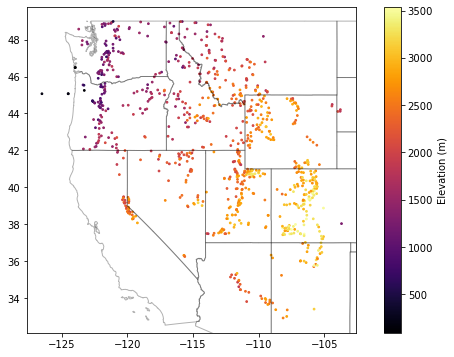

In [8]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_conus.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True, legend_kwds={'label': "Elevation (m)"})
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

In [9]:
sites_gdf_conus.to_file('~/scratch/data/uavsar/snotel/ulmo_sites.json')

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
sites_fn = '~/scratch/data/uavsar/snotel/ulmo_sites.json'
if not os.path.exists(sites_fn):
    sites_gdf_conus.to_file(sites_fn, driver='GeoJSON')

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
fp = expanduser('~/scratch/data/uavsar/images/Grand Mesa, CO/grmesa_27416_20003-028_20005-007_0011d_s01_L090_01_int_grd/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff')

with rio.open(fp, 'r+') as ds:
    msk = ds.read_masks(1)
    arr = ds.read()
    shapes = list(dataset_features(ds, bidx=1, as_mask=False, geographic=True, band=False))

In [12]:
ann_fp = '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd.csv'
a = pd.read_csv(ann_fp)
for col in a.columns:
    if 'time' in col:
        print(col)

start time of acquisition for pass 1
stop time of acquisition for pass 1
start time of acquisition for pass 2
stop time of acquisition for pass 2


In [13]:
def snotel_results(img_fp, ann_fp, snotel_gdf, variable = 'SNOTEL:SNWD_D'):
    ann = pd.read_csv(ann_fp)
    with rio.open(img_fp) as src:
        shapes = list(dataset_features(src, bidx=1, as_mask=False, geographic=True, band=False))
    result = gpd.GeoDataFrame.from_dict(shapes, crs = 'EPSG:4326')
    for i in result.index:
        result.iloc[i]['geometry'] = Polygon(result.iloc[i]['geometry']['coordinates'][0])
    boundary = gpd.GeoDataFrame(unary_union(result['geometry']), columns = ['geometry'], crs = snotel_gdf.crs)
    boundary_gdf = gpd.GeoDataFrame(boundary, columns = ['geometry'], crs = sites_gdf_conus.crs)
    points_within = gpd.sjoin(snotel_gdf, boundary_gdf, predicate='within')
    res = {}
    for site_id in points_within.index:
        res['sitecode'] = site_id
        records = snotel_fetch(site_id, variablecode=variable, start_date=ann['start time of acquisition for pass 1'], end_date=ann['start time of acquisition for pass 2'])
        res['record'] = records
    return res

In [14]:
result = gpd.GeoDataFrame.from_dict(shapes, crs = 'EPSG:4326')
for i in result.index:
    result.iloc[i]['geometry'] = Polygon(result.iloc[i]['geometry']['coordinates'][0])

/bsuhome/zacharykeskinen/miniconda3/envs/proj/lib/python3.9/site-packages/geopandas/geodataframe.py:475: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  return GeoDataFrame(dataframe, geometry=geometry, crs=crs)


In [16]:
import geopandas as gpd
from shapely.ops import unary_union

boundary = gpd.GeoDataFrame(unary_union(result['geometry']), columns = ['geometry'], crs = sites_gdf_conus.crs)

In [17]:
boundary

,geometry
0,"POLYGON ((-108.25638 38.97690, -108.25638 38.9..."
1,"POLYGON ((-108.28722 39.11691, -108.28722 39.1..."
2,"POLYGON ((-108.28772 39.11707, -108.28772 39.1..."
3,"POLYGON ((-108.28600 39.11691, -108.28600 39.1..."
4,"POLYGON ((-108.28566 39.11696, -108.28566 39.1..."
5,"POLYGON ((-108.28433 39.11780, -108.28433 39.1..."
6,"POLYGON ((-108.28866 39.11713, -108.28866 39.1..."
7,"POLYGON ((-108.28316 39.11757, -108.28316 39.1..."
8,"POLYGON ((-108.28272 39.11874, -108.28272 39.1..."
9,"POLYGON ((-108.26110 39.15724, -108.26110 39.1..."


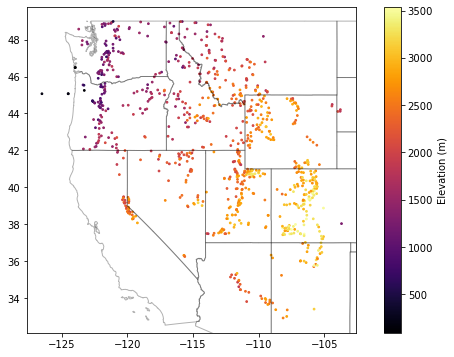

In [18]:
f, ax = plt.subplots(figsize=(10,6))
sites_gdf_conus.plot(ax=ax, column='elevation_m', markersize=3, cmap='inferno', legend=True, legend_kwds={'label': "Elevation (m)"})
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='none', edgecolor='k', alpha=0.3);

In [19]:
boundary_gdf = gpd.GeoDataFrame(boundary, columns = ['geometry'], crs = sites_gdf_conus.crs)
points_within = gpd.sjoin(sites_gdf_conus, boundary_gdf, predicate='within')

<AxesSubplot:>

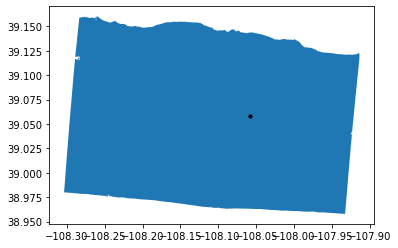

In [20]:
f,ax = plt.subplots()
boundary_gdf.plot(ax = ax)
points_within.plot(ax = ax, markersize = 10, color = 'black')

In [21]:
for site_id in points_within.index:
    sitecode = site_id

In [22]:
ulmo.cuahsi.wof.get_site_info(wsdlurl, sitecode)['series'].keys()

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:BATX_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:PREC_wy', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [23]:
#Daily SWE
#variablecode = 'SNOTEL:WTEQ_D'
#Daily snow depth
variablecode = 'SNOTEL:SNWD_D'

In [24]:
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'SNWD_D',
 'id': '176',
 'name': 'Snow depth',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

In [25]:
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

In [26]:
#Get all records, can filter later
start_date = datetime(1950,1,1)
end_date = datetime.today()

In [27]:
sitecode

'SNOTEL:622_CO_SNTL'

In [28]:
print(sitecode)
values_df = snotel_fetch(sitecode, variablecode, start_date, end_date)
values_df.shape

SNOTEL:622_CO_SNTL


(6043, 8)

In [29]:
import hvplot.pandas 
values_df.hvplot()

ModuleNotFoundError: No module named 'hvplot'

In [ ]:
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

In [ ]:
image_fps[0]

{'fp': '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VV_01.int.grd.tiff',
 'ann': '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd.csv',
 'location': 'Utica, MT'}

In [ ]:
for img_f in image_fps:
    

['/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VV_01.int.grd.tiff',
 '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VV_01.unw.grd.tiff',
 '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VH_01.int.grd.tiff',
 '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VH_01.cor.grd.tiff',
 '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_21003_21004-002_21013-003_0034d_s01_L090_01_int_grd/uticam_21003_21004-002_21013-003_0034d_s01_L090VV_01.hgt.grd.tiff',
 '/bsuscratch/zacharykeskinen/data/uavsar/images/Utica, MT/uticam_2100